In [1]:
!export CUDA_VISIBLE_DEVICES=0

import os, torch, pdb

import numpy as np 
import networkx as nx
import pandas as pd

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

from rdkit.Chem import AllChem

from escnn import gspaces, nn, group
from plotly.offline import init_notebook_mode

from vae_dist.dataset.fields import mat_pull, split_and_filter
from vae_dist.dataset.dataset import FieldDataset, dataset_split_loader
from vae_dist.core.O3VAE import R3VAE
from vae_dist.core.R3CNN import R3CNN
from vae_dist.core.VAE import baselineVAEAutoencoder
from vae_dist.core.CNN import CNNAutoencoderLightning
from vae_dist.data.visualize import get_latent_space, plot_vfield

init_notebook_mode(connected=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [4]:
from vae_dist.core.training_utils import construct_model 
import json 


options = json.load(open('./options/options_escnn_default.json'))
log_save_dir = "./log_version_escnn_1/"
model_escnn = construct_model("escnn", options)

options = json.load(open('./options/options_esvae_default.json'))
log_save_dir = "./log_version_esvae_1/"
model_esvae = construct_model("esvae", options)

options = json.load(open('./options/options_cnn_default.json'))
log_save_dir = "./log_version_auto_1/"
model_cnn = construct_model("auto", options)

options = json.load(open('./options/options_vae_default.json'))
log_save_dir = "./log_version_vae_1/"
model_vae = construct_model("vae", options)


#model.load_model("./log_version_auto_1/autoenc_1.ckpt")

inner_dim:  4
[32, 64, 128]
in_type: [O(3)_on_R3[o3]: {irrep_0,0 (x3)}(3)] out_type: [O(3)_on_R3[o3]: {irrep_0,0 (x32)}(32)]
in_type: [O(3)_on_R3[o3]: {irrep_0,0 (x32)}(32)] out_type: [O(3)_on_R3[o3]: {irrep_0,0 (x64)}(64)]
in_type: [O(3)_on_R3[o3]: {irrep_0,0 (x64)}(64)] out_type: [O(3)_on_R3[o3]: {irrep_0,0 (x128)}(128)]
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 8192]               0
            Linear-2                  [-1, 100]         819,300
              ReLU-3                  [-1, 100]               0
            Linear-4                   [-1, 10]           1,010
              ReLU-5                   [-1, 10]               0
Total params: 820,310
Trainable params: 820,310
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.06
Params size (MB): 3.13
Estima

/home/santiagovargas/anaconda3/envs/bondnet_e3nn/lib/python3.7/site-packages/torch/functional.py:478: UserWarning:

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 8192]               0
            Linear-2                  [-1, 100]         819,300
              ReLU-3                  [-1, 100]               0
            Linear-4                   [-1, 10]           1,010
              ReLU-5                   [-1, 10]               0
Total params: 820,310
Trainable params: 820,310
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.06
Params size (MB): 3.13
Estimated Total Size (MB): 3.22
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                  [-1

In [5]:
#model_esvae.load_model("./log_version_esvae_1/model_1.ckpt")
model_vae.load_model("./log_version_vae_1/model_1.ckpt")
model_cnn.load_model("./log_version_auto_1/model_1.ckpt")
model_escnn.load_model("./log_version_escnn_1/model_1.ckpt")
# move model to gpu 
model_cnn.to(device)
model_escnn.to(device)
model_esvae.to(device)
model_vae.to(device)

Model Created!
Model Created!
Model Created!


baselineVAEAutoencoder(
  (fc_mu): Linear(in_features=10, out_features=2, bias=True)
  (fc_var): Linear(in_features=10, out_features=2, bias=True)
  (encoder_conv): Sequential(
    (0): ConvBatch(
      (conv): Sequential(
        (0): Conv3d(3, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (1): Dropout(p=0.1, inplace=False)
    (2): ConvBatch(
      (conv): Sequential(
        (0): Conv3d(32, 64, kernel_size=(4, 4, 4), stride=(1, 1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (3): Dropout(p=0.1, inplace=False)
    (4): ConvBatch(
      (conv): Sequential(
        (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (5): Dropout(p=0.1, inplace=False)
    (6): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): ConvBatch(
      (conv): Sequential(
        (0): Conv3d(128, 256, kernel_size=(2, 2, 2), stride=(1, 1, 1))
        (1): ReLU(inpl

In [6]:
root = "../../data/augment_test/"
dataset_test = FieldDataset(
    root, 
    transform=False, 
    augmentation=False,
    standardize=True,
    log_scale=True, 
    device=device
    )

dataset_loader_full = torch.utils.data.DataLoader(
        dataset_test, 
        batch_size=10,
        shuffle=True,
        num_workers=0
    )

Largest value in dataset:  1.1280309724831943
Smallest value in dataset:  -1.5775816863113294


In [7]:
root = "../../data/cpet/"

dataset = FieldDataset(
    root, 
    transform=False, 
    augmentation=False,
    standardize=True,
    log_scale=True, 
    device=device
    )

Largest value in dataset:  1.0304299865539772
Smallest value in dataset:  -1.2890294168026475


# Latent Space Plotting

Total number of fields:  187


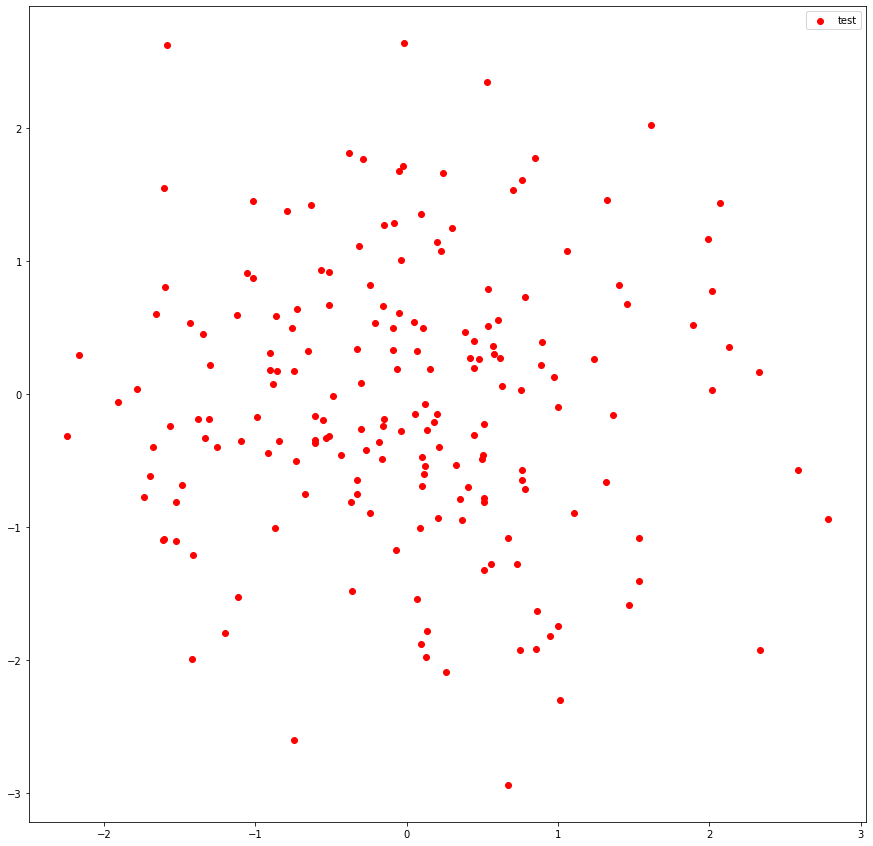

1.7845234590628065


In [13]:
model = model_esvae

plt.figure(figsize=(15, 15))
latent_space = get_latent_space(model, dataset, comp=[0, 1], latent_dim=10)
plt.scatter(latent_space[:, 0], latent_space[:, 1], c="red", label="test")
plt.legend()
plt.show()


mean_dist = 0
for i in range(latent_space.shape[0]):
    for j in range(latent_space.shape[0]):
        mean_dist += np.linalg.norm(latent_space[i] - latent_space[j])
mean_dist /= latent_space.shape[0]**2
print(mean_dist)

Total number of fields:  9


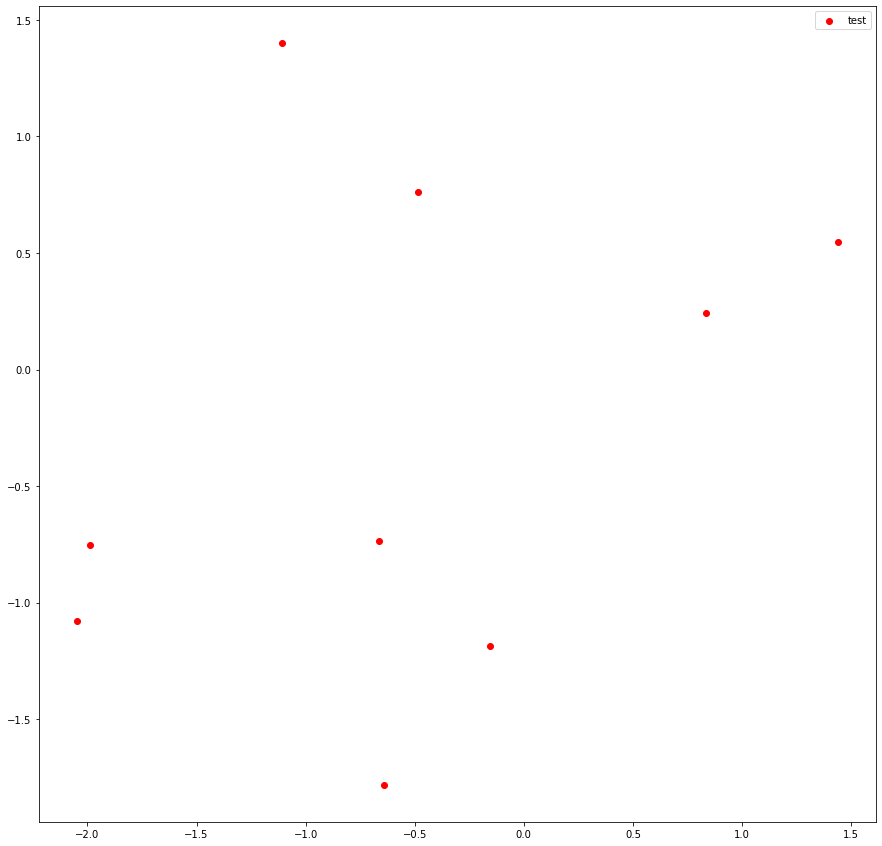

1.823052751429287


In [14]:
plt.figure(figsize=(15, 15))
latent_space = get_latent_space(model , dataset_test, comp=[0, 1], latent_dim=10)
plt.scatter(latent_space[:, 0], latent_space[:, 1], c="red", label="test")
plt.legend()
plt.show()
# compute average distance between points in latent space
mean_dist = 0
for i in range(latent_space.shape[0]):
    for j in range(latent_space.shape[0]):
        mean_dist += np.linalg.norm(latent_space[i] - latent_space[j])
mean_dist /= latent_space.shape[0]**2
print(mean_dist)

Largest value in dataset:  1.1280309724831943
Smallest value in dataset:  -1.5775816863113294
Total number of fields:  187
Total number of fields:  9


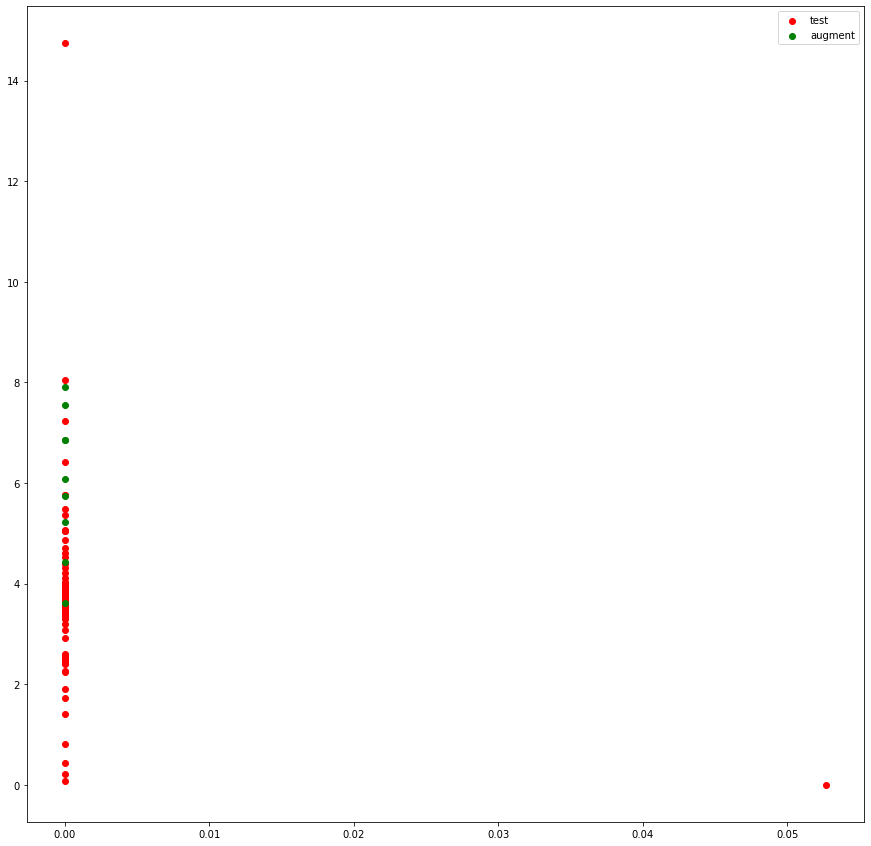

In [10]:
# Rotations on latent space

root = "../../data/augment_test/"
dataset_aug = FieldDataset(
    root, 
    transform=False, 
    augmentation=False,
    standardize=True,
    log_scale=True,
    device=device
    )


plt.figure(figsize=(15, 15))
latent_space = get_latent_space(model, dataset, comp=[0, 1])
plt.scatter(latent_space[:, 0], latent_space[:, 1], c="red", label="test")
latent_space = get_latent_space(model, dataset_aug, comp=[0, 1])
plt.scatter(latent_space[:, 0], latent_space[:, 1], c="green", label="augment")

plt.legend()
plt.show()



# run the equivariance test


In [15]:
from escnn.gspaces import gspace
groupie = group.o3_group()
gspace = gspaces.flipRot3dOnR3(maximum_frequency=10) 
input_out_reps = 3*[gspace.trivial_repr]
feat_type_in  = nn.FieldType(gspace,  input_out_reps) 

def equiv_test(model, dataset_test, device):
    print('##########################################################################################')
    with torch.no_grad():
        #x = next(iter(dataset_test)).reshape(1, 3, 21, 21, 21).to(device)
        x = dataset_test[0].reshape(1, 3, 21, 21, 21).to(device)
        y = model(x).to('cpu')
        print("Outputs' magnitudes")
        print(torch.linalg.norm(y, dim=1).numpy().reshape(-1))
        # print largest value 
        print("Largest value")
        print(torch.max(torch.linalg.norm(y, dim=1)).numpy())
        print('##########################################################################################')
        print("Errors' magnitudes")
        for r in range(8):
            # sample a random rotation
            g = groupie.sample()
            x_equi = feat_type_in(dataset_test[r].reshape(1, 3, 21, 21, 21).to(device))
            x_transformed = g @ x_equi
            x_transformed = x_transformed.to(device)
            y_transformed = model(x).to('cpu')
            
            y_group_rep = feat_type_in(y)
            # verify that f(g@x) = g@f(x)=g@y
            # print maximum error
            #print(torch.linalg.norm(y_transformed - (g@y_group_rep).tensor, dim=1).numpy().reshape(-1))        
            print("Largest error")
            print(torch.max(torch.linalg.norm(y_transformed - (g@y_group_rep).tensor, dim=1)).numpy())
    print('##########################################################################################')
    print()
equiv_test(model, dataset_test, device)

##########################################################################################
Outputs' magnitudes
[5.8863186e-14 4.7027074e-12 1.0804964e-10 ... 1.6124624e-10 7.3315052e-12
 9.5678633e-14]
Largest value
2.9692755
##########################################################################################
Errors' magnitudes
Largest error
2.154853
Largest error
4.05112
Largest error
1.3629317
Largest error
4.541944
Largest error
2.266643
Largest error
1.3579975
Largest error
1.5014356
Largest error
0.94458395
##########################################################################################



# Visualize in/out field from model


In [20]:




plot_vfield(
        dataset.data[0], 
        cutoff_low = 70, 
        cutoff_high=100, 
        min_max = False,
        scale = 2)
#fig.show()
#fig.write_html("cones_.html")

0.27 0.3 0.52


In [21]:
# model reconstruction

x = dataset_test[0].reshape(1, 3, 21, 21, 21).to(device)
x_out = model.forward(x)
x_out = x_out.to('cpu').detach().numpy().reshape(3, 21, 21, 21)

plot_vfield(
        x_out, 
        cutoff_low = 0, 
        cutoff_high=100, 
        min_max = False,
        scale = 2)


-0.14 -0.15 -0.12


# Q-Q Plot

Total number of fields:  187


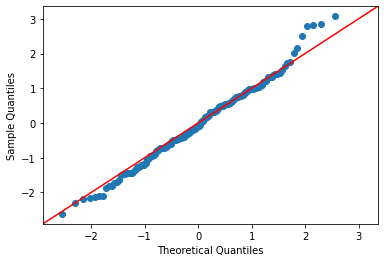

In [16]:
# q-q plot of the latent space

latent_space = get_latent_space(model, dataset, comp=[0, 1], latent_dim=10)

import scipy.stats as stats
import pylab 
import statsmodels.api as sm
sm.qqplot(latent_space[:,1], line='45')
pylab.show()



In [17]:
latent_space = get_latent_space(model, dataset, latent_dim=10)
component = 2
plt.scatter(latent_space[:, component], latent_space[:, component], c="red", label="test")


Total number of fields:  187


IndexError: index 2 is out of bounds for axis 1 with size 2